## Neural machine translation: English-to-Spanish

- Approach: sequence-to-sequence model (encoder-decoder architecture) with attention and teacher forcing 
- Advantages of Attention:
  - Regular seq-to-seq model: The entire orginal language sequence must fit into one small vector as the final output state from encoder LSTMs/GRUs. If the sequence is very long, the single output state can not capture all the information in the input sequence.
  - Attention: For each output, attention tells the model which part of the input sequence should be paid attention to.
- Result: 
  - Compared to regular sequence to sequence model , sequence to sequence model with attention can increase the prediction accuracy by a promising amount.
  - Due to computation and time limit, the model only ran 10 epochs on 10000 samples. Increasing number of epochs and sample size will increase the translation accuracy.

In [1]:
# Disable warnings
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

In [5]:
# custom softmax_over_time function
# in Keras 2.1.5, we can pass the axis = 1 directly, but not for old versions of Keras
# for each t = 1,...,Ty, we have alpha of shape: (N, Tx, 1) where N is the batch_size
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis = 1, keepdims = True))
    s = K.sum(e, axis = 1, keepdims = True)
    return e/s

In [6]:
# configuration
batch_size = 64
epochs = 10
latent_dim = 256
latent_dim_decoder = 256
num_samples = 10000
max_sequence_length = 100
max_num_words = 20000
embedding_dim = 100

In [7]:
# prepare the training data
input_texts = []
target_texts = []
target_texts_inputs = []

t = 0
for line in open('../large_files/translation/spa.txt'):
    t += 1
    if t > num_samples:
        break
    if '\t' not in line:
        continue
    input_text, translation = line.rstrip().split('\t')
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)

print("number of samples to train on: ", len(input_texts))

number of samples to train on:  10000


In [8]:
# Tokenize the input sentences (in original language)
tokenizer_inputs = Tokenizer(num_words = max_num_words)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)
# word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print("number of unique input tokens: ", len(word2idx_inputs))

max_len_input = max(len(s) for s in input_sequences)

number of unique input tokens:  2367


In [9]:
# Tokenize the output sentences (in translated language)
tokenizer_outputs = Tokenizer(num_words = max_num_words, filters = '')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)
# word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print("number of unique output tokens: ", len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_len_target = max(len(s) for s in target_sequences)

number of unique output tokens:  6325


In [10]:
# pad sequences to form tensor
encoder_inputs = pad_sequences(input_sequences, maxlen = max_len_input)
print("shape of encoder inputs: ", encoder_inputs.shape)

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen = max_len_target, padding = 'post')
print("shape of decoder inputs: ", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen = max_len_target, padding = 'post')

shape of encoder inputs:  (10000, 5)
shape of decoder inputs:  (10000, 9)


In [11]:
# prepare pre-trained glove word embedding vectors
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % embedding_dim)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype = 'float32')
        word2vec[word] = vec

num_words = min(max_num_words, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word2idx_inputs.items():
    if i < max_num_words:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [12]:
# create embedding layer
embedding_layer = Embedding(
    num_words,
    embedding_dim,
    weights = [embedding_matrix],
    input_length = max_len_input,
    trainable = False
)

In [13]:
# prepare targets
# one-hot-encoding targets
# sparse_... loss without one-hot encoding does not work on sequence format targets
decoder_targets_one_hot = np.zeros(
    (len(input_texts), max_len_target, num_words_output),
    dtype = 'float32'
)
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

### Model buiding and training

In [14]:
#### Encoder
encoder_inputs_placeholder = Input(shape = (max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(latent_dim, return_sequences = True, dropout = 0.5))
encoder_outputs = encoder(x)


#### Decoder
decoder_inputs_placeholder = Input(shape = (max_len_target,))
decoder_embedding = Embedding(num_words_output, embedding_dim)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)


#### Attention
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis = -1) # concatenate s(t-1) and h(t'), will be repeated max_len_input times
attn_dense1 = Dense(10, activation = 'tanh') # for each [s(t-1), h(t')] where t'=1,...,Ty
attn_dense2 = Dense(1, activation = softmax_over_time)
attn_dot = Dot(axes = 1) # weighted sum of alpha(t')*h(t')

def one_step_attention(h, st_1):
    # h = h(1),...,h(Tx) of shape (Tx, latent_dim*2)
    # st_1 = s(t-1) of shape (latent_dim_decoder)
    
    # copy st_1 Tx times
    st_1 = attn_repeat_layer(st_1) # of shape (Tx, latent_dim_decoder)
    
    # concatenate all h(1),...,h(Tx) with s(t-1)
    x = attn_concat_layer([h, st_1]) # of shape (Tx, latent_dim_decoder + latent_dim*2)
    
    # dense layer1
    x = attn_dense1(x)
    
    # dense layer2 with softmax over time
    alphas = attn_dense2(x)
    
    # context = weight sum of h
    context = attn_dot([alphas, h])
    
    return context


#### rest of decoder
decoder_lstm = LSTM(latent_dim_decoder, return_state = True)
decoder_dense = Dense(num_words_output, activation = 'softmax')

initial_s = Input(shape = (latent_dim_decoder,), name = 's0')
initial_c = Input(shape = (latent_dim_decoder,), name = 'c0')
context_last_word_concat_layer = Concatenate(axis = 2) # teacher forcing: concatenate last word and context as input to decoder LSTM


#### output sequences
# Different from regular seq-to-seq model, we can't get output in one step
# Need to loop over Ty steps, in each step, we calculate a context
s = initial_s
c = initial_c

outputs = []
for t in range(max_len_target):
    context = one_step_attention(encoder_outputs, s)
    
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_inputs_x)
    
    decoder_lstm_input = context_last_word_concat_layer([context, xt])
    
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state = [s, c])
    
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)
   
    # outputs is a list of length Ty
    # each element is of shape (batch_size, output_vocab_size)
    # if simply stack, shape will be Ty x N x D
    # we want N x T x D


def stack_and_transpose(x):
    x = K.stack(x)
    x = K.permute_dimensions(x, pattern = (1, 0, 2))
    return x

# in Keras, every function needs to be packed to a layer using Lambda
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)


#### Create the Model
model = Model(
    inputs = [encoder_inputs_placeholder, decoder_inputs_placeholder, initial_s, initial_c],
    outputs = outputs
)

model.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [15]:
# train the model
z = np.zeros((num_samples, latent_dim_decoder)) # initial [s, c]
r = model.fit(
    [encoder_inputs, decoder_inputs, z, z],
    decoder_targets_one_hot,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.2
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 119s 15ms/step - loss: 2.7686 - acc: 0.6280 - val_loss: 2.7640 - val_acc: 0.6471
Epoch 2/10
8000/8000 [==============================] - 116s 15ms/step - loss: 2.1054 - acc: 0.7070 - val_loss: 2.4949 - val_acc: 0.6687
Epoch 3/10
8000/8000 [==============================] - 120s 15ms/step - loss: 1.8955 - acc: 0.7237 - val_loss: 2.3860 - val_acc: 0.6794
Epoch 4/10
8000/8000 [==============================] - 112s 14ms/step - loss: 1.7624 - acc: 0.7359 - val_loss: 2.2420 - val_acc: 0.6907
Epoch 5/10
8000/8000 [==============================] - 112s 14ms/step - loss: 1.6646 - acc: 0.7447 - val_loss: 2.1888 - val_acc: 0.7019
Epoch 6/10
8000/8000 [==============================] - 112s 14ms/step - loss: 1.5779 - acc: 0.7544 - val_loss: 2.1283 - val_acc: 0.7063
Epoch 7/10
8000/8000 [==============================] - 112s 14ms/step - loss: 1.4994 - acc: 0.7629 - val_loss: 2.1114 - val_acc: 

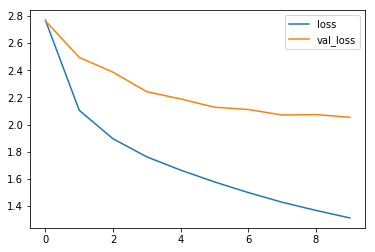

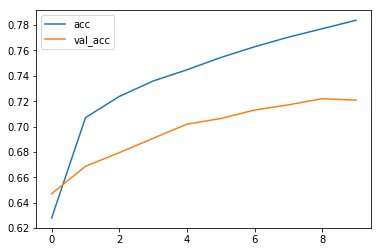

In [16]:
# Visalization loss and accuracy
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label = 'acc')
plt.plot(r.history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()

### Make predictions

In [17]:
# Encoder model
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# Decoder model with T = 1
encoder_outputs_as_input = Input(shape = (max_len_input, latent_dim*2,))
decoder_inputs_single = Input(shape = (1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

context = one_step_attention(encoder_outputs_as_input, initial_s)

decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

o, s, c = decoder_lstm(decoder_lstm_input, initial_state = [initial_s, initial_c])
decoder_outputs = decoder_dense(o) # of shape: N x D, no need to make from 1 x N x D -> N x 1 x D

decoder_model = Model(
    inputs = [decoder_inputs_single, encoder_outputs_as_input, initial_s, initial_c],
    outputs = [decoder_outputs, s, c]
)

In [18]:
# map index back to original language and translated language
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [21]:
def decode_sequence(input_seq):
    enc_out = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1, 1))
    target_seq[0,0] = word2idx_outputs['<sos>']
    
    # if generated index is eos, break
    eos = word2idx_outputs['<eos>']
    
    # initial s, c
    s = np.zeros((1, latent_dim_decoder))
    c = np.zeros((1, latent_dim_decoder))
    
    output_sequence = []
    for _ in range(max_len_target):
        o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        idx = np.argmax(o.flatten())
        if idx == eos:
            break
        
        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sequence.append(word)
        
        target_seq[0, 0] = idx
    
    return ' '.join(output_sequence)

In [22]:
while True:
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('-')
    print('Input: ', input_texts[i])
    print('Predicted translation: ', translation)
    print('Actual translation: ', target_texts[i])
    
    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break

-
Input:  Is this a river?
Predicted translation:  ¿es un libro.
Actual translation:  ¿Es ese un río? <eos>
Continue? [Y/n]Y
-
Input:  He is nasty.
Predicted translation:  él es gentil.
Actual translation:  Él es un guarro. <eos>
Continue? [Y/n]Y
-
Input:  Drive slowly.
Predicted translation:  sigue de adelante.
Actual translation:  Conduce lentamente. <eos>
Continue? [Y/n]Y
-
Input:  I love eggplant.
Predicted translation:  me gustan los gustan los gustan los gustan los
Actual translation:  Me encantan las berenjenas. <eos>
Continue? [Y/n]Y
-
Input:  He lay face up.
Predicted translation:  él se se quedó llorar.
Actual translation:  Él estaba tirado de espaldas. <eos>
Continue? [Y/n]Y
-
Input:  She has a book.
Predicted translation:  él es un libro.
Actual translation:  Tiene un libro. <eos>
Continue? [Y/n]Y
-
Input:  Saddle my horse.
Predicted translation:  me duele el perro.
Actual translation:  Ensilla mi caballo. <eos>
Continue? [Y/n]Y
-
Input:  We're busy.
Predicted translation: 